<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [85]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [87]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [88]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [89]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [90]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=20, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [91]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [92]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [93]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [94]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [95]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 10, 5, 5]           4,010
              ReLU-2             [-1, 10, 5, 5]               0
 AdaptiveAvgPool2d-3             [-1, 10, 1, 1]               0
           Flatten-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
Total params: 4,120
Trainable params: 4,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
Task 0 Start!
Epoch	1	Acc:  0.5121, Loss:  0.0066
Epoch	2	Acc:  0.7517, Loss:  0.0034
Epoch	3	Acc:  0.8009, Loss:  0.0026
Epoch	4	Acc:  0.8273, Loss:  0.0023
Epoch	5	Acc:  0.8454, Loss:  0.0020
Epoch	6	Acc:  0.8609, Loss:  0.0019
Epoch	7	

 - Task 0

Accuracy 0.6576
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.91      0.82      0.86       980
     1 - one       0.96      0.75      0.84      1135
     2 - two       0.75      0.72      0.73      1032
   3 - three       0.76      0.28      0.41      1010
    4 - four       0.42      0.72      0.53       982
    5 - five       0.61      0.77      0.68       892
     6 - six       0.64      0.91      0.75       958
   7 - seven       0.79      0.62      0.70      1028
   8 - eight       0.46      0.31      0.37       974
    9 - nine       0.56      0.67      0.61      1009

    accuracy                           0.66     10000
   macro avg       0.69      0.66      0.65     10000
weighted avg       0.69      0.66      0.65     10000



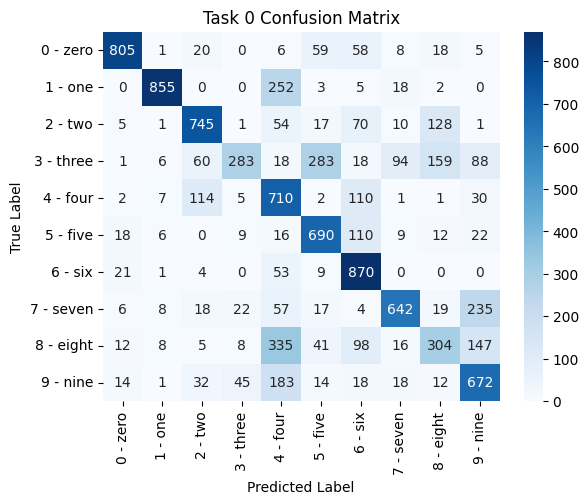

In [96]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.4631
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.67      0.74      0.70       980
     1 - one       0.85      0.94      0.89      1135
     2 - two       0.24      0.29      0.26      1032
   3 - three       0.35      0.34      0.34      1010
    4 - four       0.33      0.33      0.33       982
    5 - five       0.28      0.22      0.25       892
     6 - six       0.33      0.29      0.31       958
   7 - seven       0.64      0.79      0.71      1028
   8 - eight       0.29      0.19      0.23       974
    9 - nine       0.39      0.40      0.40      1009

    accuracy                           0.46     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.45      0.46      0.45     10000



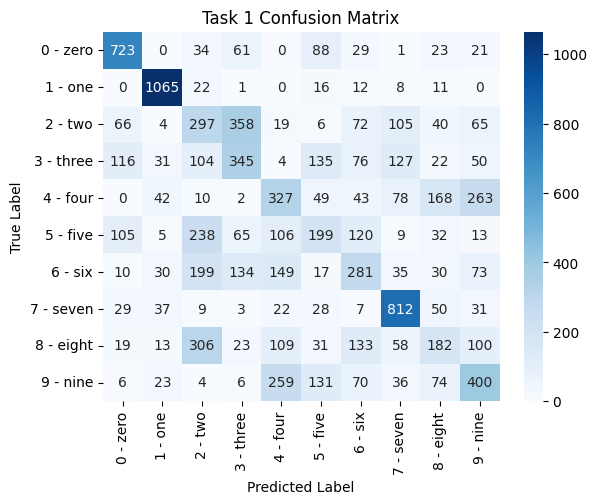

In [97]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 20, 20])
Max fisher is 0.02481 and it's parameter diff is 0.00098
Min Parameter diff is 1.38572 and it's fisher is 0.00002
fisher > parameter diff: 56
fisher <= parameter diff: 344


<Figure size 640x480 with 0 Axes>

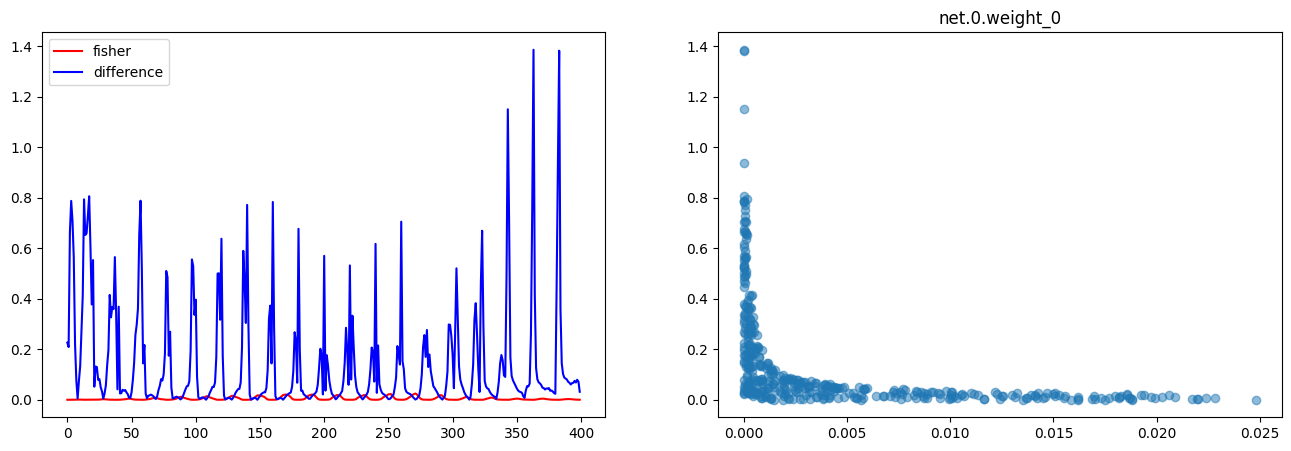

Max fisher is 0.02262 and it's parameter diff is 0.03115
Min Parameter diff is 1.41917 and it's fisher is 0.00000
fisher > parameter diff: 47
fisher <= parameter diff: 353


<Figure size 640x480 with 0 Axes>

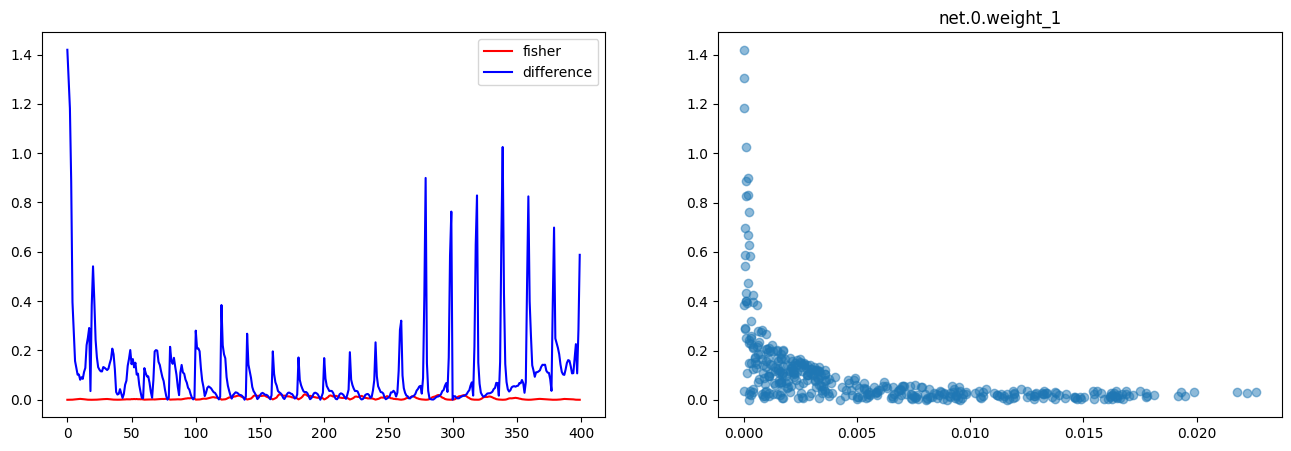

Max fisher is 0.03640 and it's parameter diff is 0.00593
Min Parameter diff is 1.46784 and it's fisher is 0.00001
fisher > parameter diff: 151
fisher <= parameter diff: 249


<Figure size 640x480 with 0 Axes>

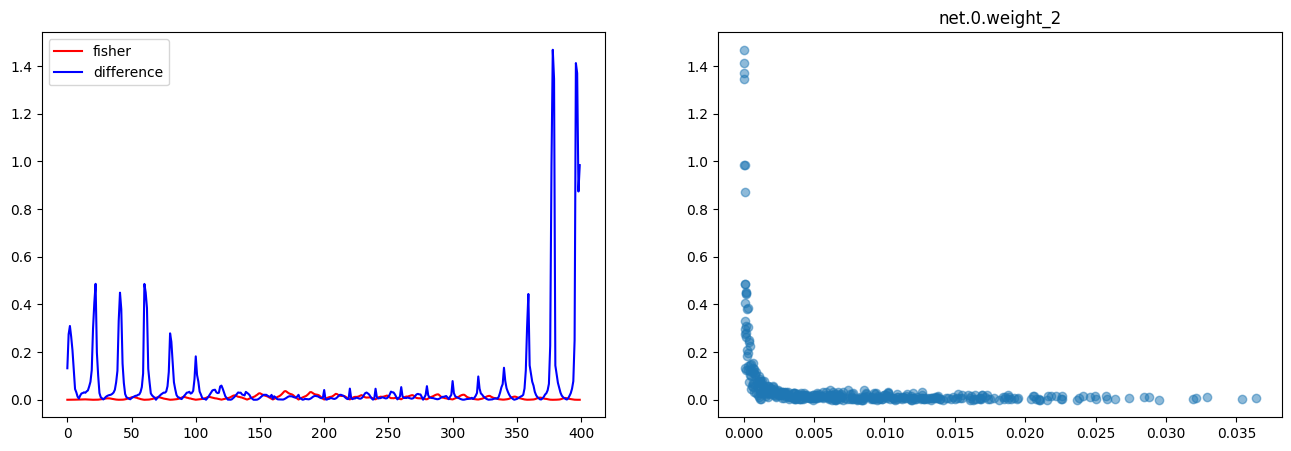

Max fisher is 0.00721 and it's parameter diff is 0.00041
Min Parameter diff is 1.37417 and it's fisher is 0.00001
fisher > parameter diff: 16
fisher <= parameter diff: 384


<Figure size 640x480 with 0 Axes>

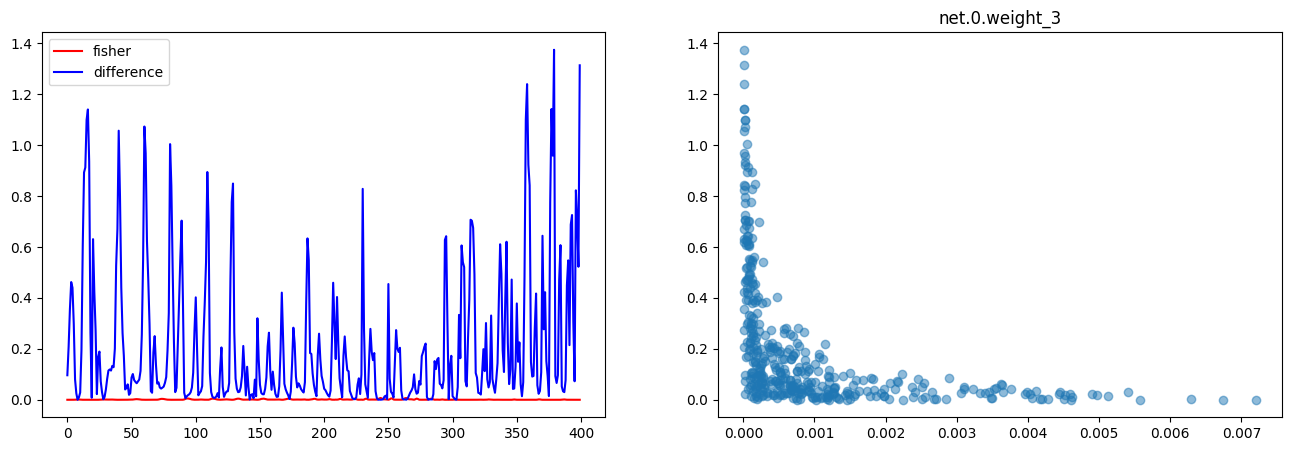

Max fisher is 0.12749 and it's parameter diff is 0.00261
Min Parameter diff is 1.71652 and it's fisher is 0.00005
fisher > parameter diff: 268
fisher <= parameter diff: 132


<Figure size 640x480 with 0 Axes>

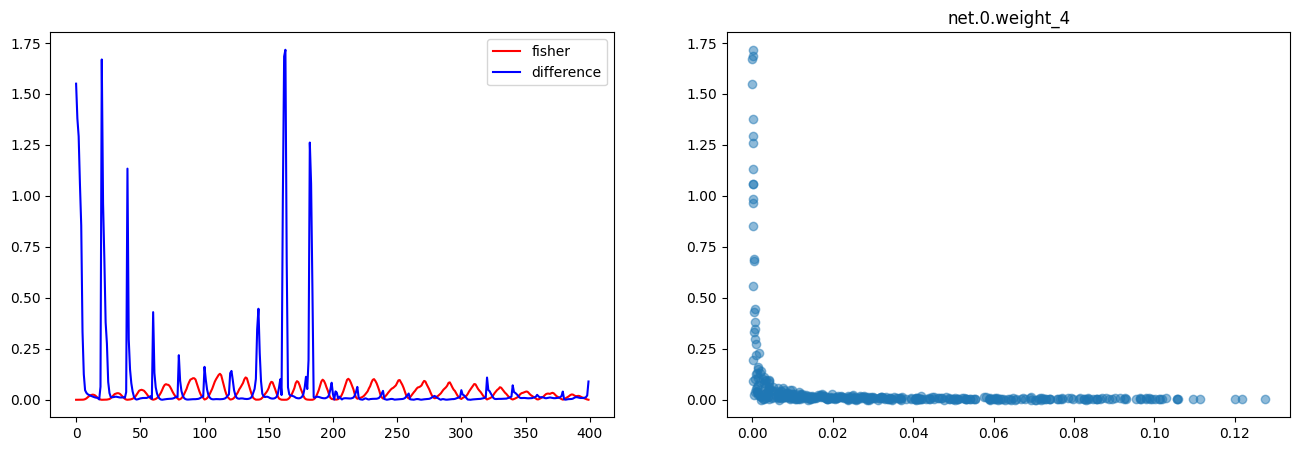

Max fisher is 0.11502 and it's parameter diff is 0.00410
Min Parameter diff is 1.74616 and it's fisher is 0.00005
fisher > parameter diff: 298
fisher <= parameter diff: 102


<Figure size 640x480 with 0 Axes>

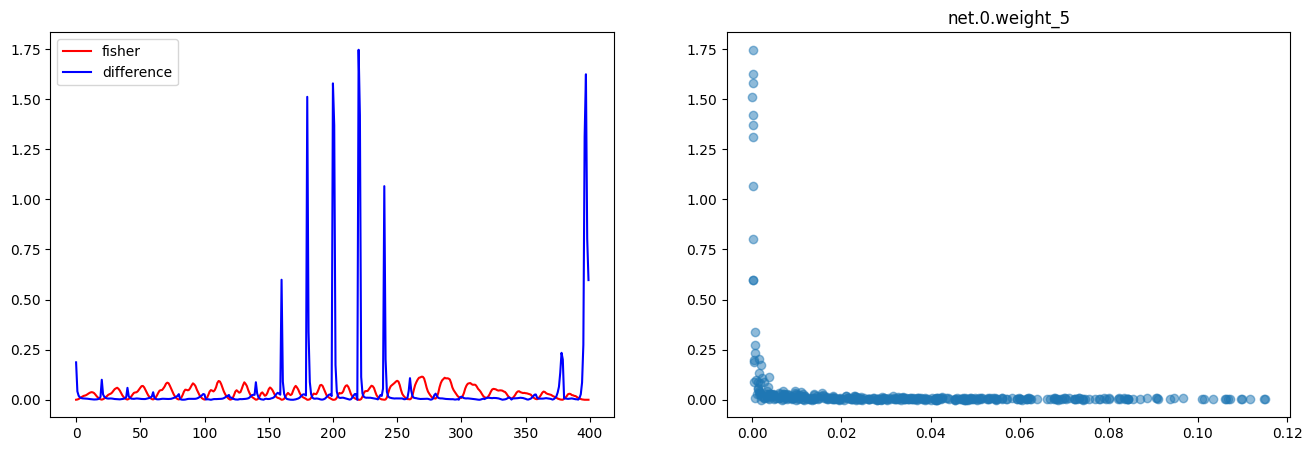

Max fisher is 0.00783 and it's parameter diff is 0.03300
Min Parameter diff is 1.58252 and it's fisher is 0.00002
fisher > parameter diff: 18
fisher <= parameter diff: 382


<Figure size 640x480 with 0 Axes>

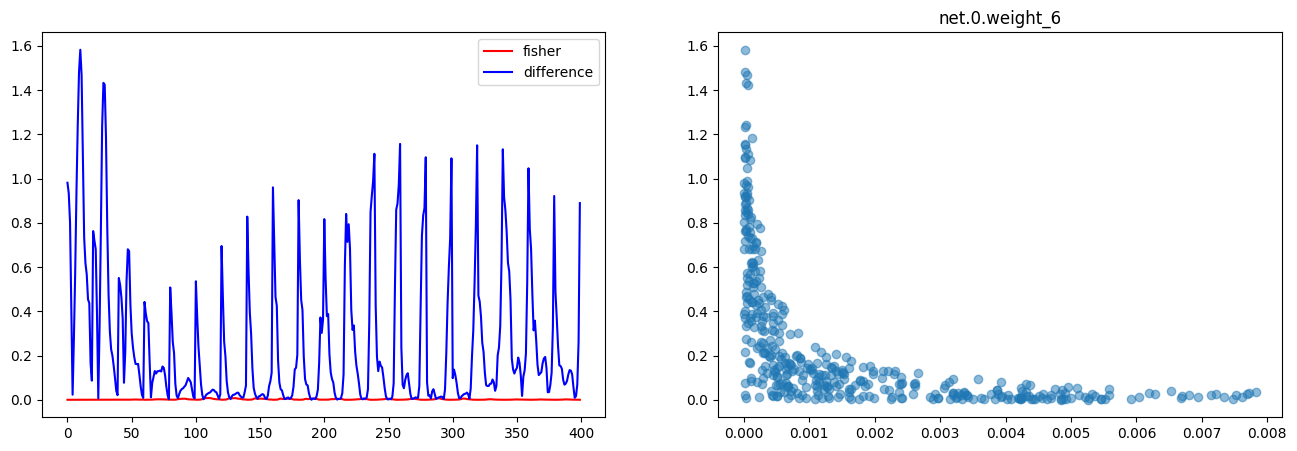

Max fisher is 0.02968 and it's parameter diff is 0.00809
Min Parameter diff is 1.64642 and it's fisher is 0.00006
fisher > parameter diff: 61
fisher <= parameter diff: 339


<Figure size 640x480 with 0 Axes>

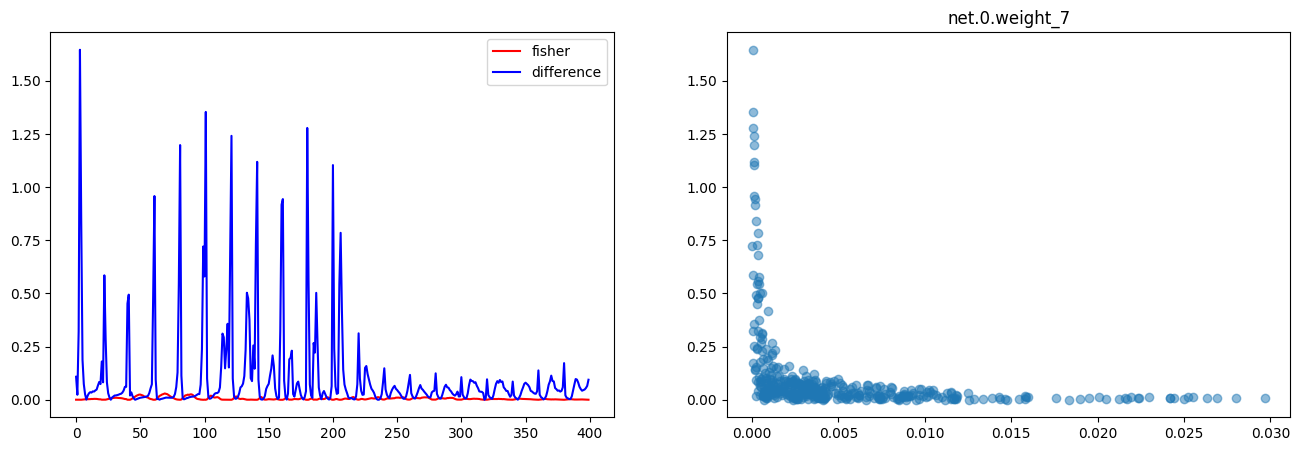

Max fisher is 0.02369 and it's parameter diff is 0.01347
Min Parameter diff is 1.42412 and it's fisher is 0.00004
fisher > parameter diff: 12
fisher <= parameter diff: 388


<Figure size 640x480 with 0 Axes>

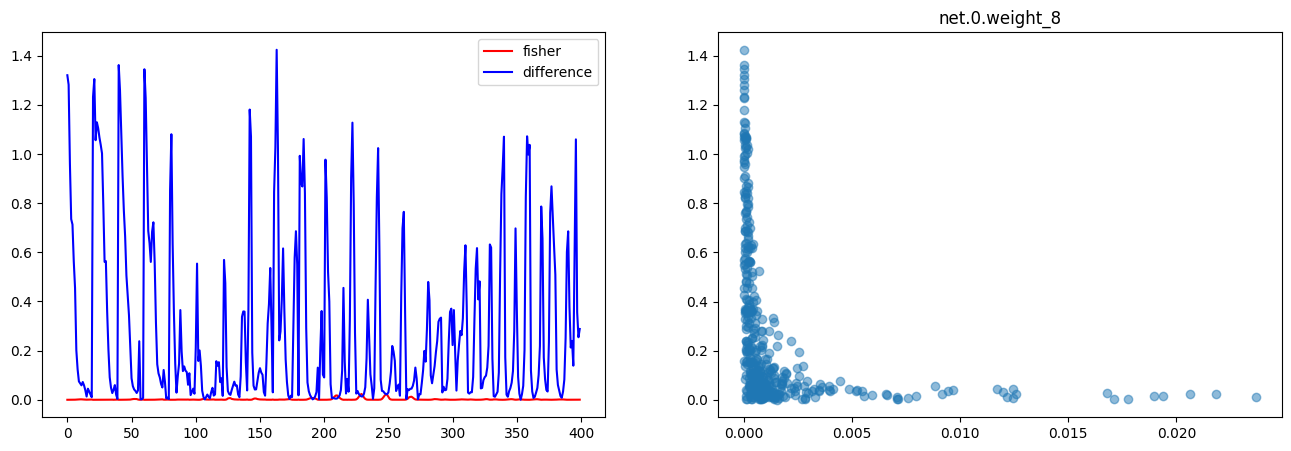

Max fisher is 0.12627 and it's parameter diff is 0.00479
Min Parameter diff is 1.65318 and it's fisher is 0.00002
fisher > parameter diff: 262
fisher <= parameter diff: 138


<Figure size 640x480 with 0 Axes>

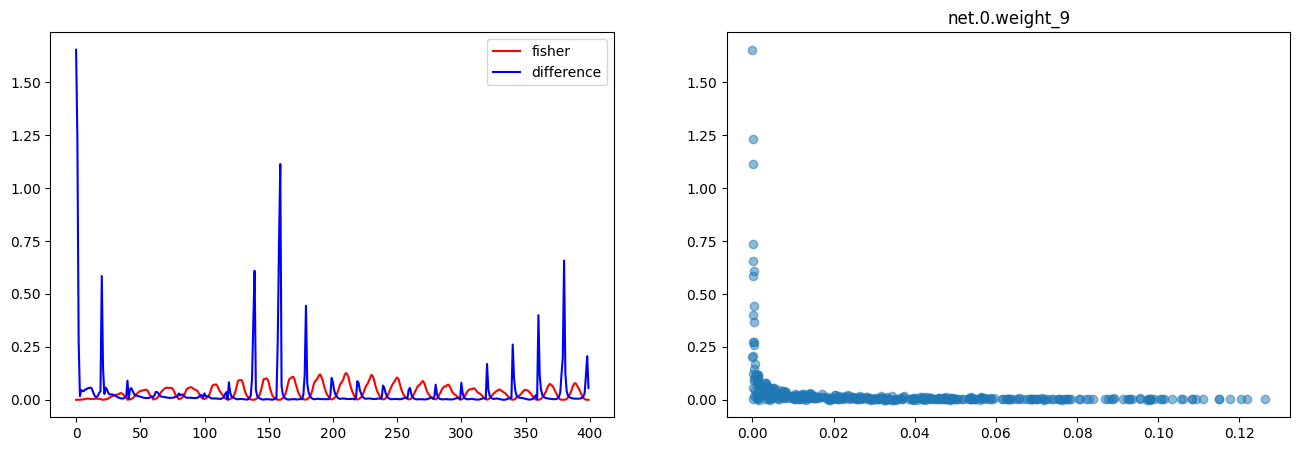


net.0.bias
torch.Size([10])
Max fisher is 0.39612 and it's parameter diff is 0.00131
Min Parameter diff is 0.02368 and it's fisher is 0.00879
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

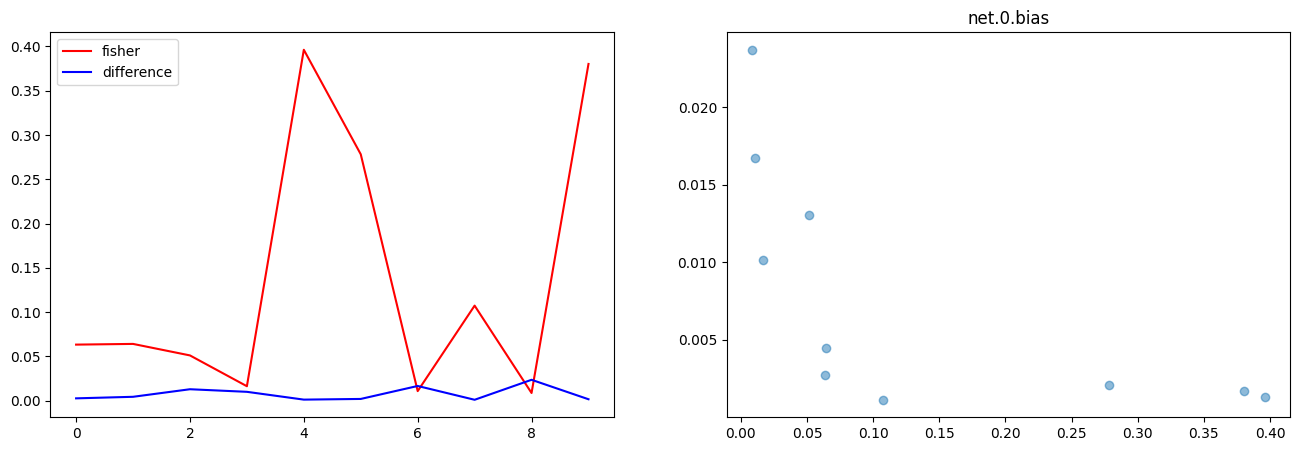


net.4.weight
torch.Size([10, 10])
Max fisher is 27.53976 and it's parameter diff is 0.00006
Min Parameter diff is 0.00522 and it's fisher is 0.11585
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

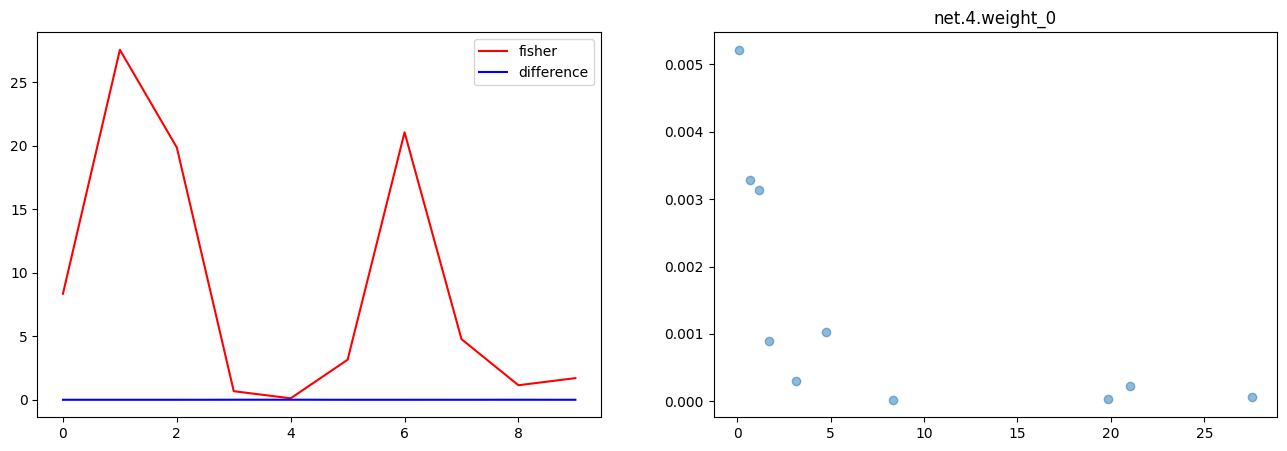

Max fisher is 2.04782 and it's parameter diff is 0.00200
Min Parameter diff is 0.10250 and it's fisher is 0.01337
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

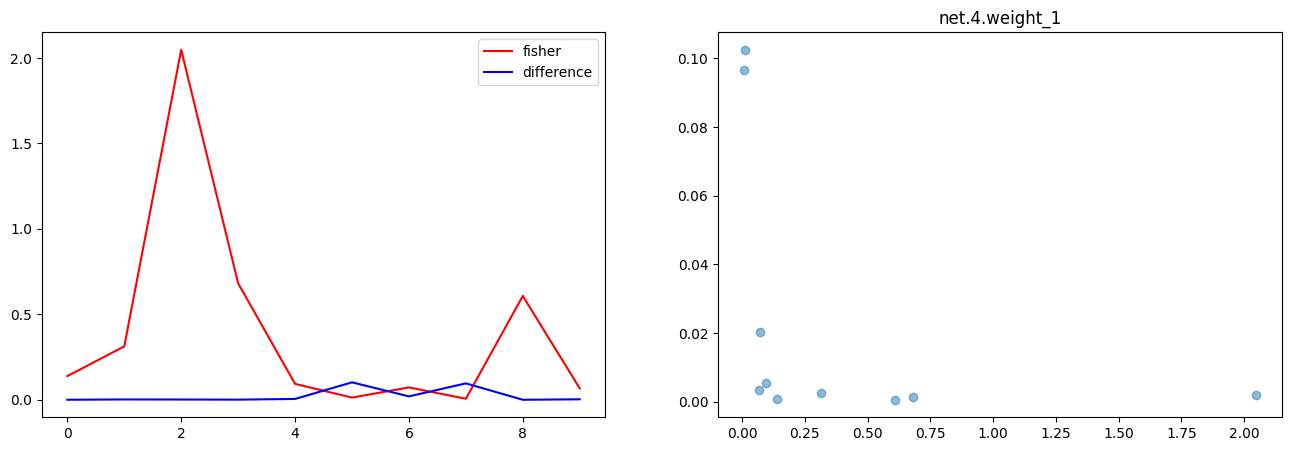

Max fisher is 9.09074 and it's parameter diff is 0.00107
Min Parameter diff is 0.00711 and it's fisher is 0.09954
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

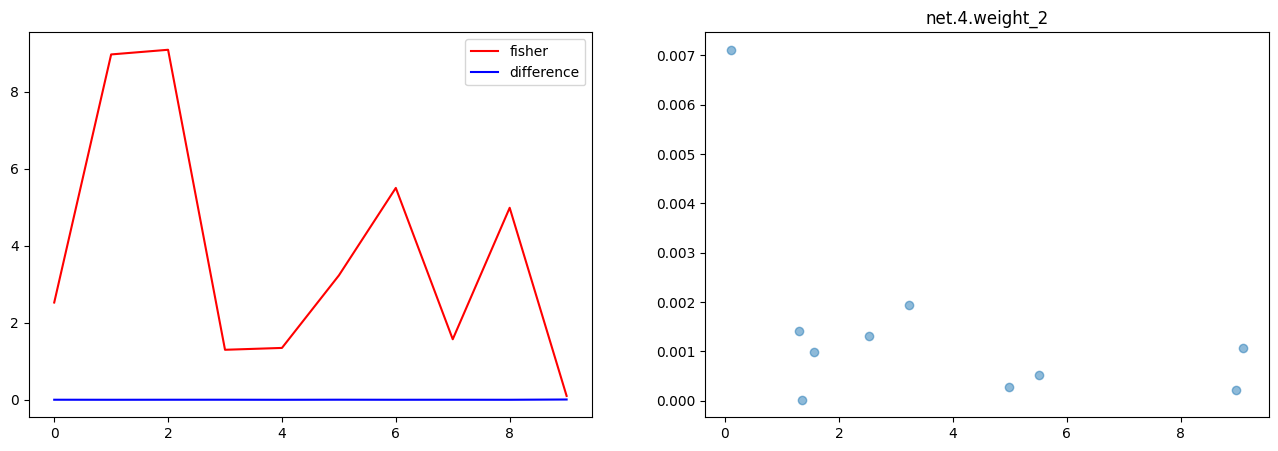

Max fisher is 67.62020 and it's parameter diff is 0.00030
Min Parameter diff is 0.00163 and it's fisher is 6.07812
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

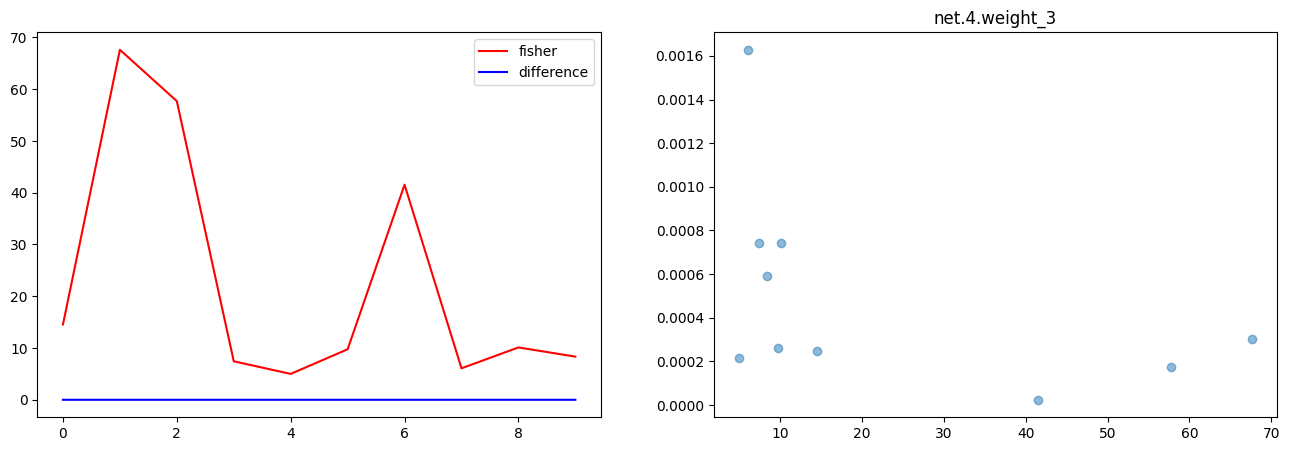

Max fisher is 28.53686 and it's parameter diff is 0.00011
Min Parameter diff is 0.00736 and it's fisher is 0.91218
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

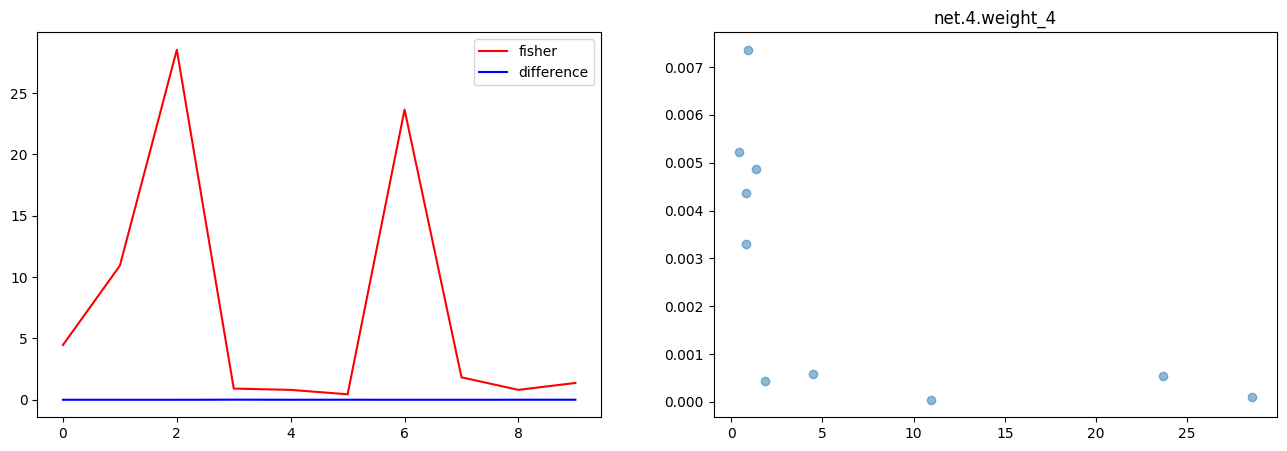

Max fisher is 16.48353 and it's parameter diff is 0.00005
Min Parameter diff is 0.01147 and it's fisher is 0.48587
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

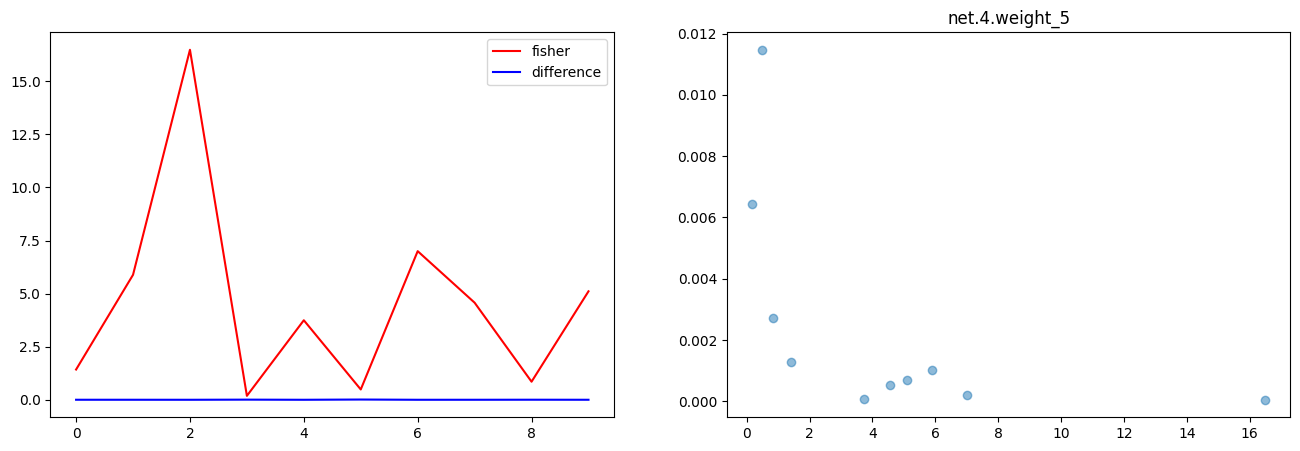

Max fisher is 15.45391 and it's parameter diff is 0.00025
Min Parameter diff is 0.01901 and it's fisher is 0.14803
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

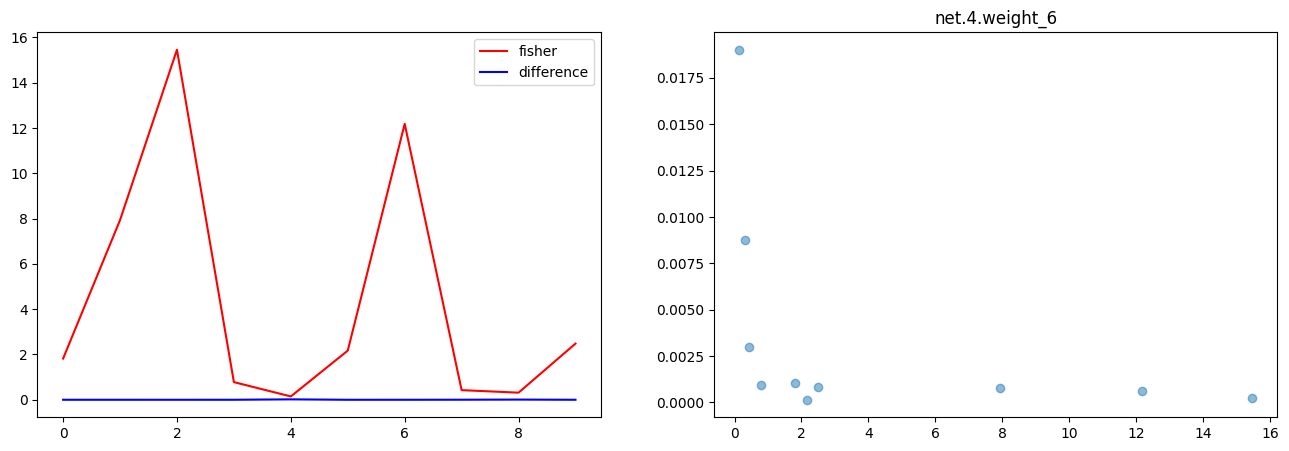

Max fisher is 3.32020 and it's parameter diff is 0.00005
Min Parameter diff is 0.02525 and it's fisher is 0.02351
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

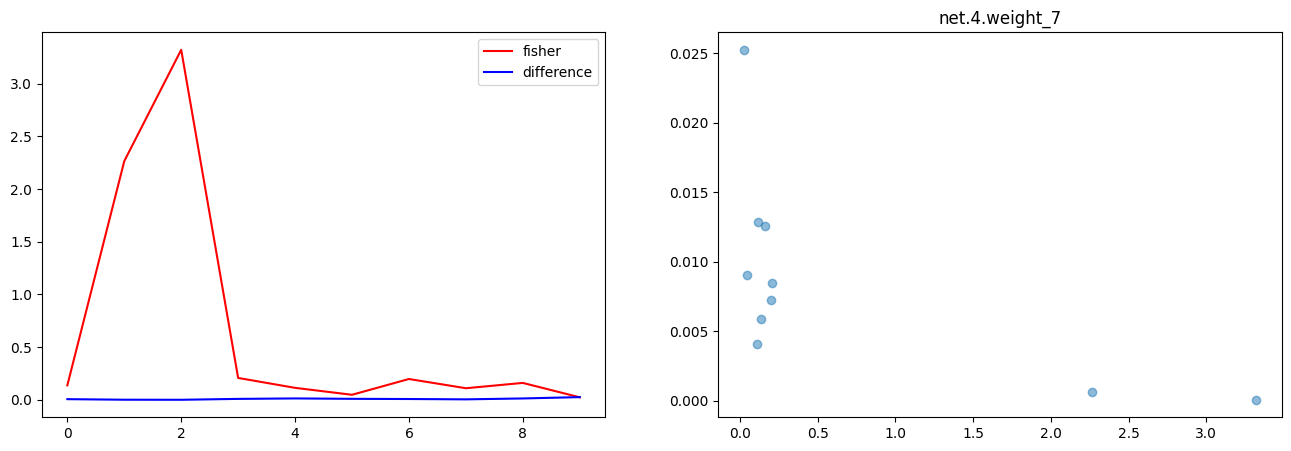

Max fisher is 2.52850 and it's parameter diff is 0.00133
Min Parameter diff is 0.11594 and it's fisher is 0.03028
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

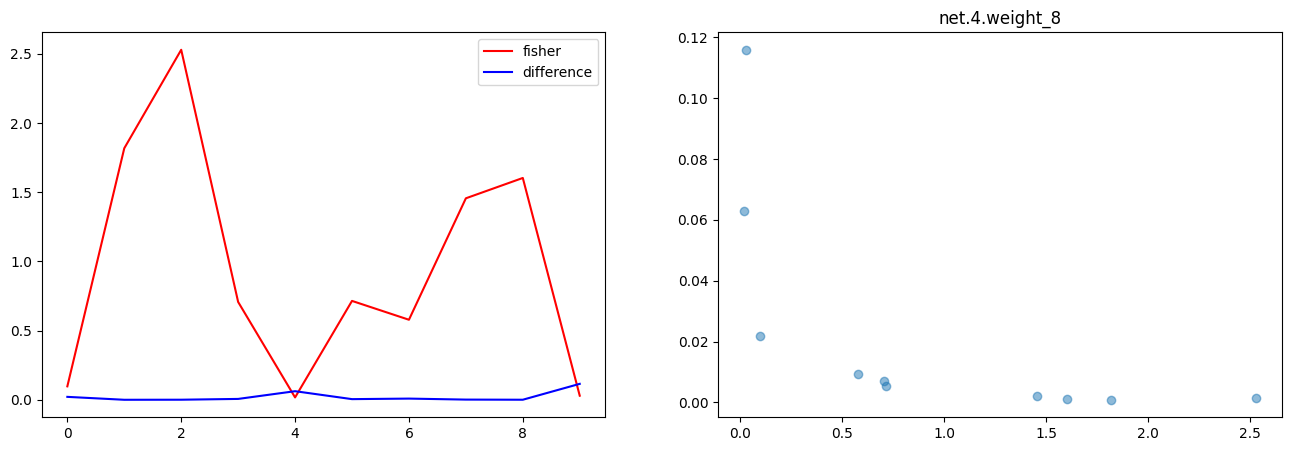

Max fisher is 12.62088 and it's parameter diff is 0.00002
Min Parameter diff is 0.06740 and it's fisher is 0.03357
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

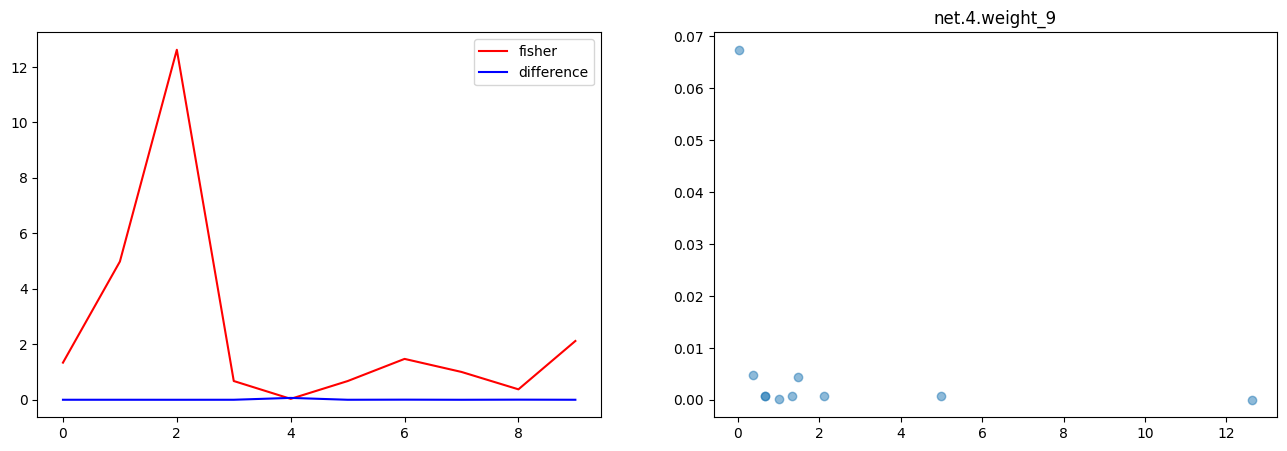


net.4.bias
torch.Size([10])
Max fisher is 0.35549 and it's parameter diff is 0.00166
Min Parameter diff is 0.05489 and it's fisher is 0.01967
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

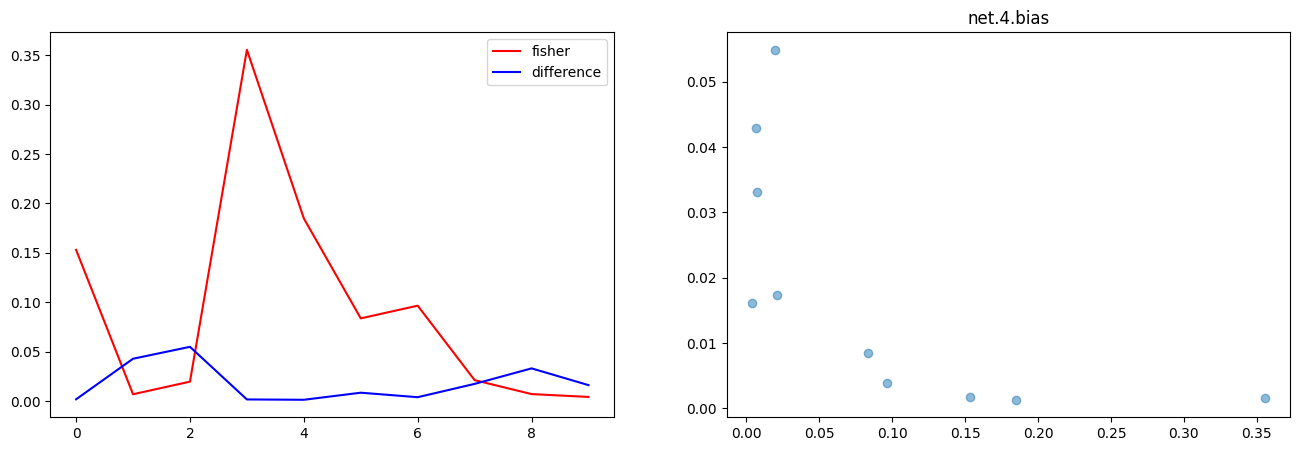

In [98]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [99]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_18_36_15
